In [5]:
using Crystalline, MPBUtils, JLD2, LinearAlgebra, StaticArrays, SymmetryBases, PyPlot, DelimitedFiles, PrettyTables, Brillouin
using PyCall
np = pyimport("numpy")

PyObject <module 'numpy' from '/home/gridsan/aligho/.local/lib/python3.8/site-packages/numpy/__init__.py'>

In [193]:
include("plotting_utilities.jl")

plotiso (generic function with 5 methods)

In [9]:
#This is the 501x501 kmesh we use for the nodal point calculations
#
ks = Vector{Vector{Float64}}()
N = 500
for i in 1:N+1
for j in 1:N+1
    kx = (i-1)/N - 0.5
    ky = (j-1)/N - 0.5
    push!(ks, [kx, ky])
end
end
#=for idx in 1:200
    open("nodal_points/input/kpoints-$idx.sh", "w") do io 
        write(io, "kvecs=(list ")
        for k in ks[idx:200:length(ks)]
            kx, ky = k
            write(io, "(vector3 $(kx) $(ky)) ")
        end
        write(io, ")")
    end
end=#

In [7]:
# Function transforms a vector k that is in the reciprocal basis to the cartesian basis
function wigner_seitz(k::Vector{<:Real}, Gs::ReciprocalBasis)
    b1, b2 = Gs
    kbasis = hcat(b1, b2)
    return kbasis*k
end

wigner_seitz (generic function with 1 method)

In [8]:
good_candidatesv = Dict{Tuple{String, Integer, Integer, Integer}, Float64}[] #mode, id_eps, id, top band, margin (total id including id_eps offset) 
                                                                # This is a vector- each element corresponds to sgs 2, 10, 16 respectively
for sg in [2, 10, 16]
    println("Calculating for sg: $sg"); flush(stdout)
    good_candidates = Dict{Tuple{String, Integer, Integer, Integer}, Float64}() # Dictionary for each space group
    #good_candidates_unrestricted = Dict{Tuple{String, Integer, Integer, Integer}, Float64}() # Dictionary for each space group
    # By unrestricted we mean that we don't restrict within the first few band groupings
    for id_eps in 1:3
        println("Calculating for id_eps: $id_eps"); flush(stdout)
        for mode = ["te", "tm"];
            dispersion_dir = "./dispersions/output/sg$sg/eps$(id_eps)/$mode/";
            loaded_dispersion_data = load(dispersion_dir*"sg$sg-epsid$(id_eps)-res64-$mode.jld2")
            marginsv = loaded_dispersion_data["marginsv"];
            cumsummariesv = loaded_dispersion_data["cumsummariesv"];
            for (id, (margins, cumsummaries)) in enumerate(zip(marginsv, cumsummariesv))
                real_id = id + (10000)*(id_eps-1)
                for (cumsum_idx, (margin, cumsummary)) in enumerate(zip(margins, cumsummaries))
                    if cumsum_idx <= 3 # We only want candidates with nontrivial bands at low frequencies
                        cumsummary.topology == NONTRIVIAL || continue
                        top_band = cumsummary.band[end]
                        push!(good_candidates, (mode, id_eps, real_id, top_band) => margin)
                    end
                end
            end
        end
    end
    push!(good_candidatesv, good_candidates)
end

Calculating for sg: 2
Calculating for id_eps: 1
Calculating for id_eps: 2
Calculating for id_eps: 3
Calculating for sg: 10
Calculating for id_eps: 1
Calculating for id_eps: 2
Calculating for id_eps: 3
Calculating for sg: 16
Calculating for id_eps: 1
Calculating for id_eps: 2
Calculating for id_eps: 3


In [9]:
nodal_point_calcnames = String[]
nodal_point_data = Dict{String, Tuple{Float64, Integer, String, Integer, Integer}}() # margin, id_eps, mode, id, top_band 
for (good_candidates, sg) in zip(good_candidatesv, [2, 10, 16])
    best_candidates = collect(sort(good_candidates, byvalue=true, rev=true))
    for best_candidate in best_candidates[1:10]
        (mode, id_eps, id, band), margin = best_candidate #findmax(good_candidates)
        push!(nodal_point_data, "dim2-sg$sg-$id-res64-$mode" => (margin, id_eps, mode, id, band))
        push!(nodal_point_calcnames, "dim2-sg$sg-$id-res64-$mode")
    end
end

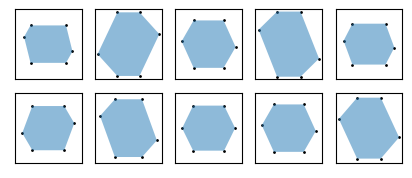

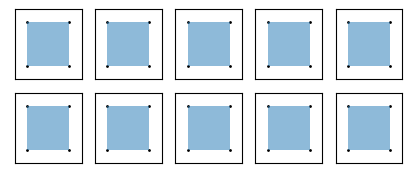

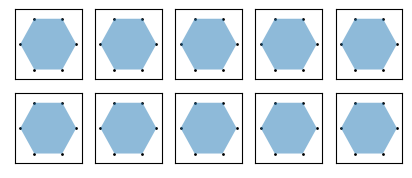

In [10]:
#Plotting the shapes of the Brillouin zones- note that for spacegroup 2, the brillouin zones are all different
#Since we have a free parameter
for (i, nodal_point_calcname) in enumerate(nodal_point_calcnames)
    if i == 1 || i == 11 || i == 21
        figure(figsize=(5, 2))
    end
    
    subplot(2, 5, mod(i, 10) + 1)
    xs = Float64[]
    ys = Float64[]

    Rs = first(lattice_from_mpbparams("./nodal_points/input/"*nodal_point_calcname*".sh"))
    Gs = reciprocalbasis(Rs)
    verts = wignerseitz(Gs).verts;
    faces = wignerseitz(Gs).faces;
    for vert in verts
        x, y = Gs[1]*vert[1] + Gs[2]*vert[2]
        scatter(x, y, color="black", s =1)
        push!(xs, x)
        push!(ys, y)
    end
    fill(xs, ys, alpha=0.5)
    xlim(-5, 5)
    ylim(-5, 5)
    xticks(Float64[])
    yticks(Float64[])
end

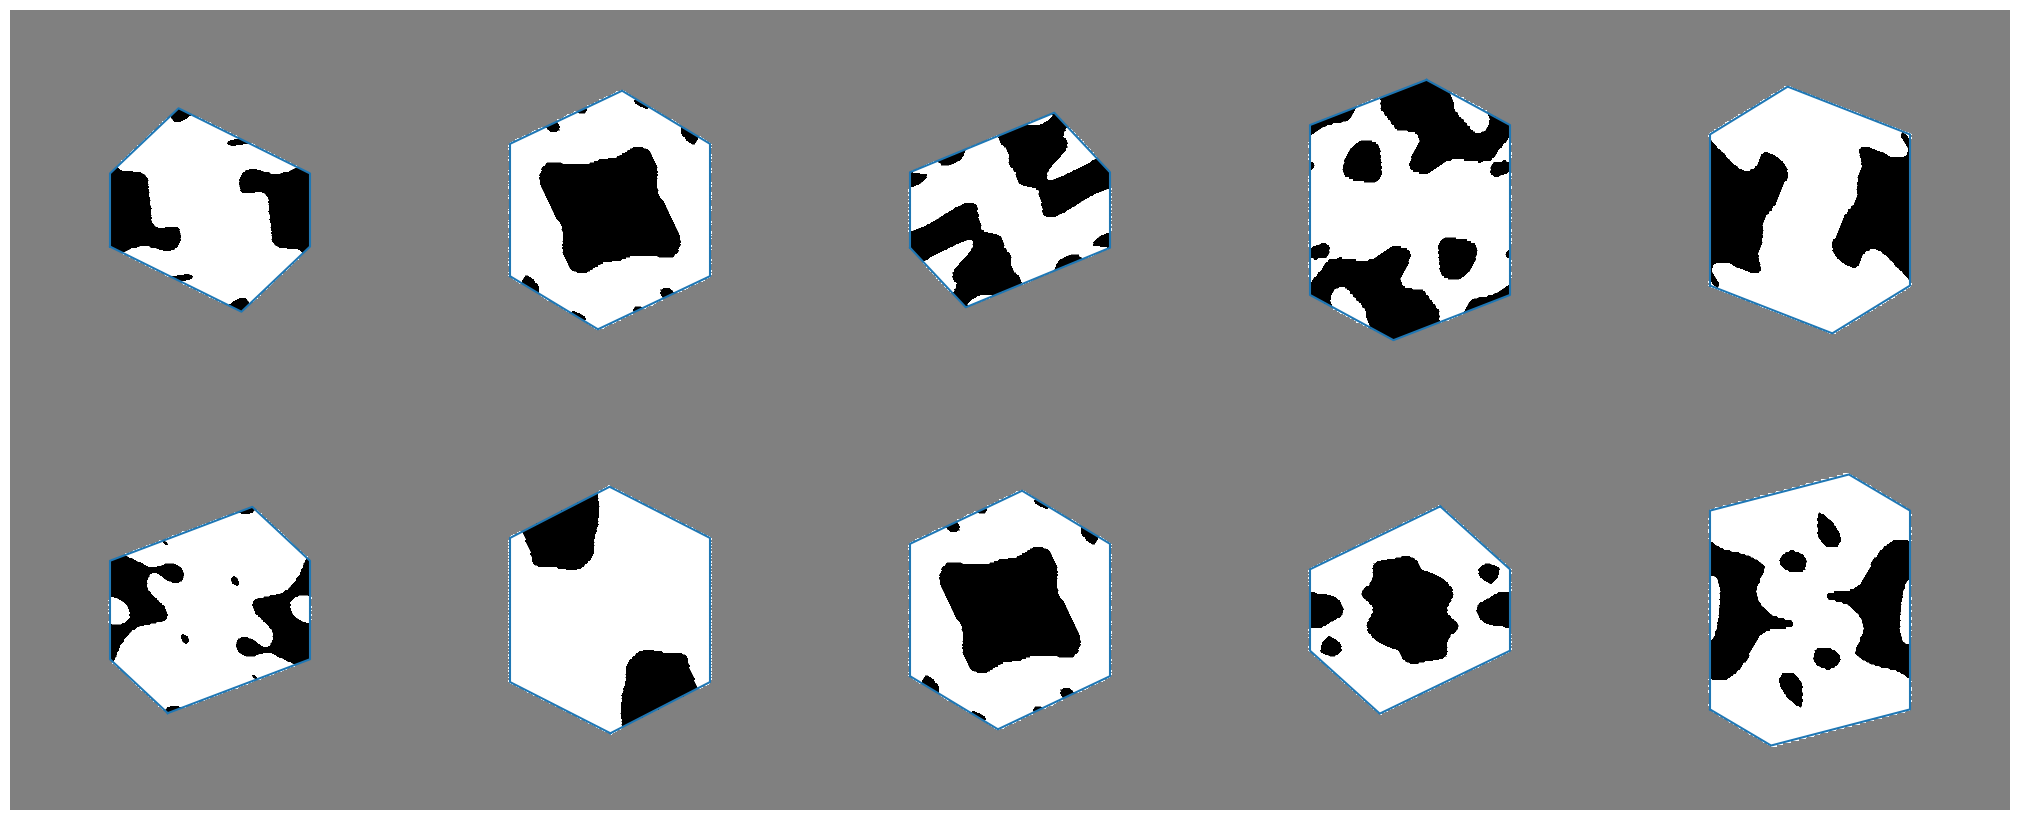

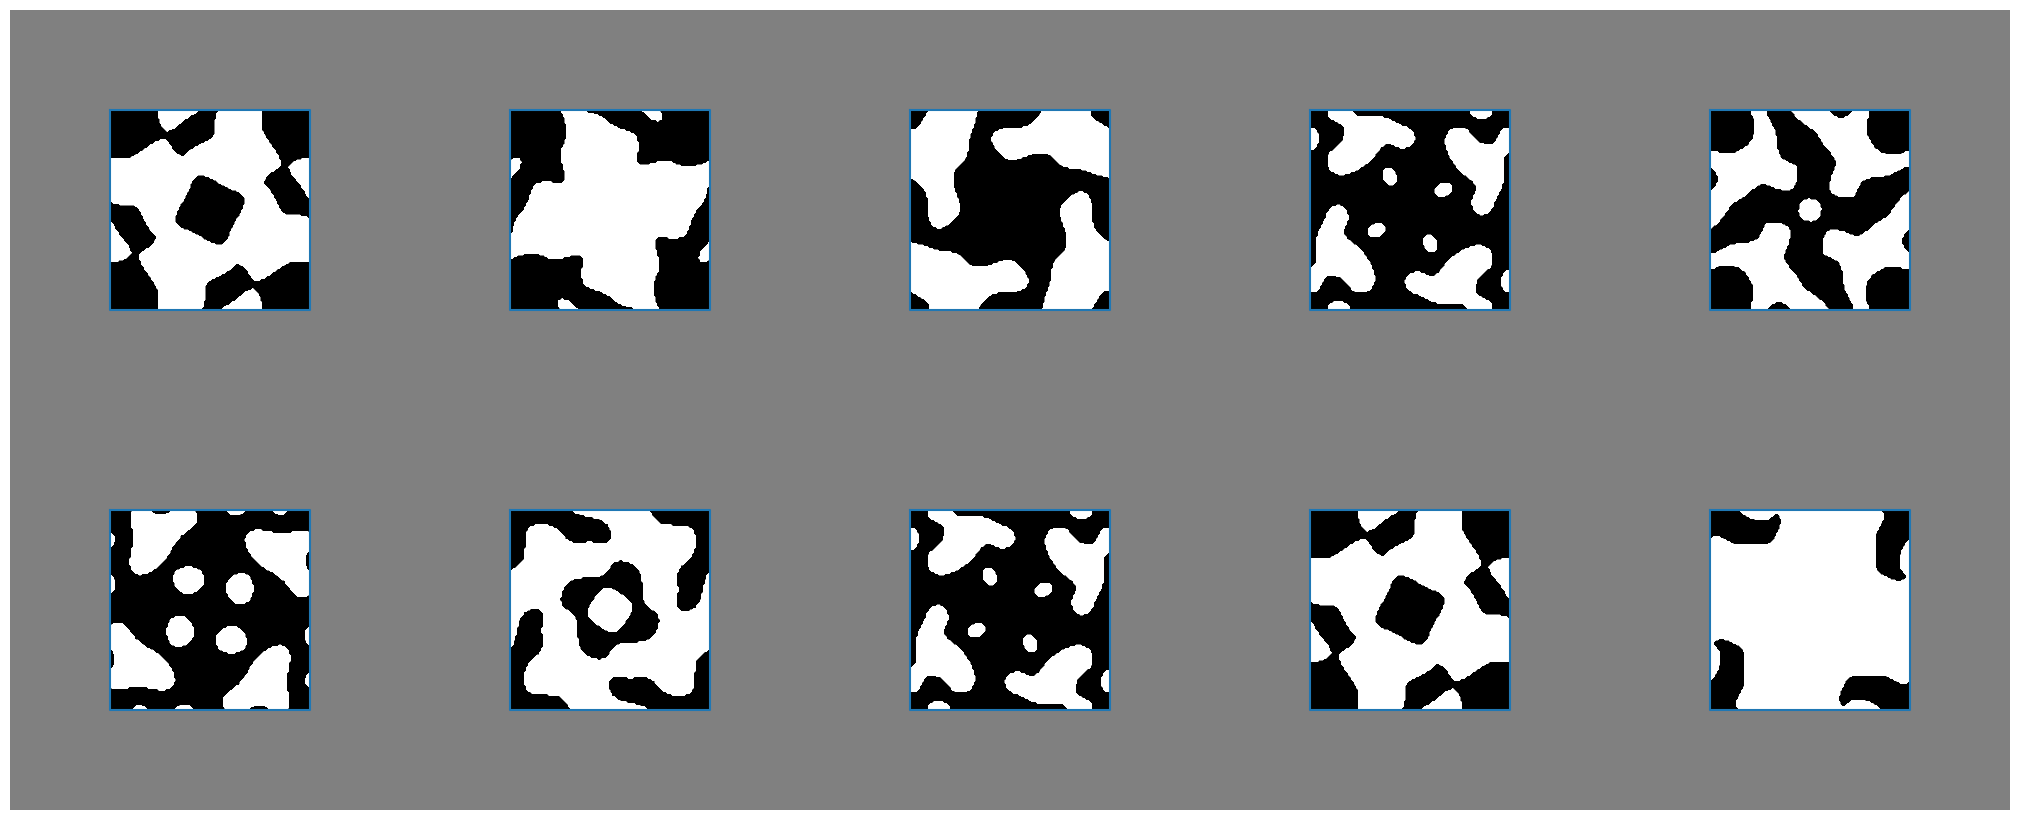

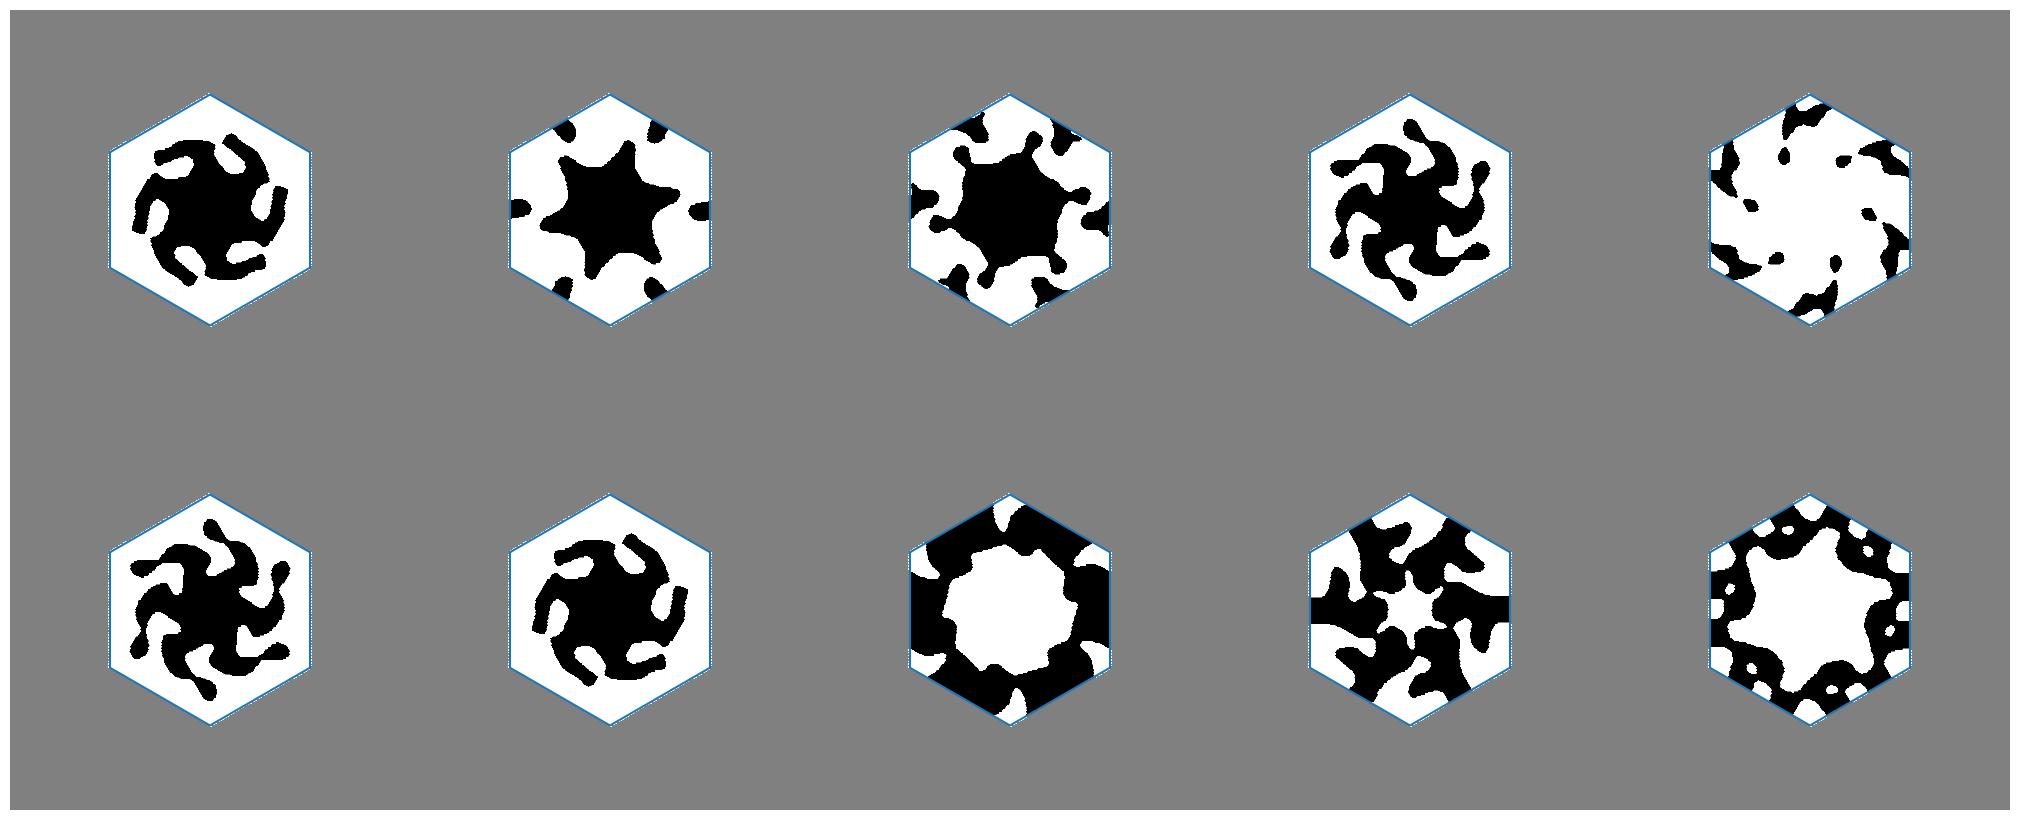

In [219]:
for (i, nodal_point_calcname) in enumerate(nodal_point_calcnames)
    fig = if (i == 1 || i == 11 || i == 21)
        figure(figsize=(40, 20))
    else
        gcf()
    end
    j = mod(i, 10)
    j = (j == 0 ? 10 : j)
    row = j > 5 ? 1 : 2
    column = mod(j, 5)
    column = (column == 0 ? 5 : column)
    ax = fig.add_axes([column*0.1, row*0.2, 0.1, 0.2])
    title =
    if i == 1
        "SG 2 Candidates"
    elseif i == 11
        "SG 10 Candidates"
    elseif i == 21
        "SG 16 Candidates"
    else 
        " " 
    end
    calcname = "./dispersions/input/"*nodal_point_calcname*".sh"
    Rs, flat, isoval, _ = lattice_from_mpbparams(calcname)
    wigner_cell = wignerseitz(Rs)
    wigner_plot(flat, Rs, wigner_cell; isoval=isoval, fig=fig, ax=gca(), in_polygon=true, xyz = range(-2.5, 2.5, length=600),  N=100, translation_vector=[0, 0])
end

In [139]:
#=for nodal_point_calcname in nodal_point_calcnames
    cp("./dispersions/input/$nodal_point_calcname", "./nodal_points/input/$nodal_point_calcname")
end=#

dim2-sg2-23318-res64-te


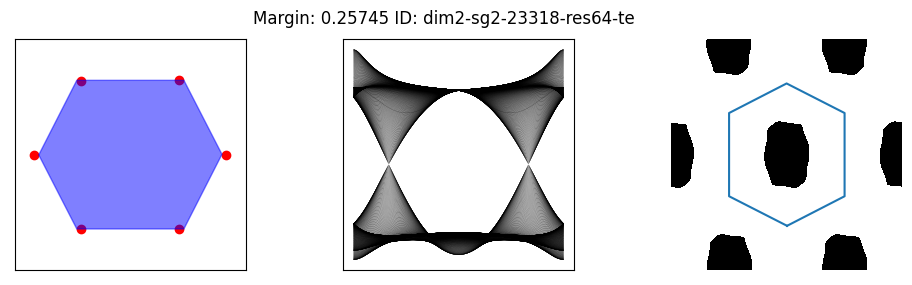

2


In [38]:
for nodal_point_calcname in nodal_point_calcnames[7:7]
    println(nodal_point_calcname); flush(stdout)
    num_nodal_points = 
        if MPBUtils.parse_sgnum(nodal_point_calcname) == 2
            2
        elseif MPBUtils.parse_sgnum(nodal_point_calcname) == 10 
            4
        else 
            6
        end
    
    fig = figure(figsize=(12,3))
    subplot(1, 3, 1)
    margin, id_eps, mode, real_id, top_band = nodal_point_data[nodal_point_calcname]
    println(top_band)
    band1 = zeros(501*501)
    band2 = zeros(501*501)
    all_bands = zeros(501*501, 11)
    for idx in 1:200
        dispersion = readdlm("nodal_points/output/$nodal_point_calcname-$idx-dispersion.out", ',', Float64)
        dispersion = sort(dispersion[:, 6:end], dims = 2)
        lower_dispersion = dispersion[:, top_band]
        upper_dispersion = dispersion[:, top_band+1]
        gap = minimum(upper_dispersion - lower_dispersion)
        gap < 0 && (println("Negative Gap at idx: $idx"); flush(stdout); println(argmin(upper_dispersion - lower_dispersion)))
        band1[idx:200:end] =  lower_dispersion 
        band2[idx:200:end] =  upper_dispersion 
        all_bands[idx:200:end, :] = dispersion
    end
    xs = Float64[]
    ys = Float64[]
    
    Rs, flat, isoval, _= lattice_from_mpbparams("./nodal_points/input/"*nodal_point_calcname*".sh")
    Gs = reciprocalbasis(Rs)
    verts = wignerseitz(Gs).verts;
    faces = wignerseitz(Gs).faces;
    for vert in verts
        x, y = Gs[1]*vert[1] + Gs[2]*vert[2]
        #scatter(x, y, color="black")
        push!(xs, x)
        push!(ys, y)
    end
    fill(xs, ys, alpha=0.5, color="blue")
    xlim(-5, 5)
    ylim(-5, 5)
    xticks(Float64[])
    yticks(Float64[])
    theta = 2π/num_nodal_points
    rotation_matrix = [cos(theta) -sin(theta); sin(theta) cos(theta)]
    #nodal_point_locations = ks[sortperm(band2-band1)[1:num_nodal_points]]
    nodal_point_value = band1[argmin(band2 - band1)]
    for idx_1 in -1:1
        for idx_2 in -1:1
            for i in 1:num_nodal_points
                k = (rotation_matrix^i) * wigner_seitz(ks[argmin(band2-band1)] + [idx_1, idx_2], Gs)
                #k in nodal_point_locations
                scatter(k..., color="red")
            end
            #X = [k[1] for k in wigner_seitz.([k + [idx_1, idx_2] for k in ks], Ref(Gs))]
            #Y = [k[2] for k in wigner_seitz.([k + [idx_1, idx_2] for k in ks], Ref(Gs))]
            #X = reshape(X, (501, 501))
            #Y = reshape(Y, (501, 501));
            #contour(X, Y, reshape(log.(band2 .- nodal_point_value), (501, 501)), 0, cmap="hot")
        end
    end
    suptitle("Margin: $(round(margin, digits=5)) ID: $nodal_point_calcname")
    
    xleft, xright = gca().get_xlim()
    ydown, yup = gca().get_ylim()
    gca().set_aspect((xright-xleft)/(yup-ydown))

    subplot(1, 3, 2)
    for yidx in 1:501
        plot(reshape(band2, (501, 501))[1:501, yidx], color="black", linewidth=0.1)
        plot(reshape(band1, (501, 501))[1:501, yidx], color="black", linewidth=0.1)
    end
    xleft, xright = gca().get_xlim()
    ydown, yup = gca().get_ylim()
    gca().set_aspect((xright-xleft)/(yup-ydown))

    
    xticks(Float64[])
    yticks(Float64[])
    subplot(1, 3, 3)

    wigner_cell = wignerseitz(Rs)
    wigner_plot(flat, Rs, wigner_cell; isoval=isoval, fig=fig, ax=gca(), translation_vector=[0, 0.5], xyz = range(-2, 2, length=300))
    savefig("$(nodal_point_calcname)_nodal_point.pdf")
end